In [1]:
import os
import torch
import numpy as np
import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
from utils import image_grid
# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes, Textures

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SilhouetteShader, PhongShader, PointLights, TexturedPhongShader
)

In [2]:
# Set the cuda device 
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Load the obj and ignore the textures and materials.
verts, faces_idx, _ = load_obj("/home/hyosung/ImageDataset/PoseDataset/lm_full/models_obj/obj_000009.obj")
# verts, faces_idx, _ = load_obj("/home/hyosung/ImageDataset/PoseDataset/lm_full/models_obj/teapot.obj")
faces = faces_idx.verts_idx

# vertices align to center
verts[:,0] -= verts[:,0].mean()
verts[:,1] -= verts[:,1].mean()
verts[:,2] -= verts[:,2].mean()
# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
model_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

In [3]:
# Initialize an OpenGL perspective camera.
cameras = OpenGLPerspectiveCameras(device=device)

# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. Refer to rasterize_meshes.py
# for an explanation of this parameter. 
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
    bin_size=0
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SilhouetteShader(blend_params=blend_params)
)


# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    bin_size=0
)
# We can add a point light in front of the object. 
lights = PointLights(device=device, location=((0.0, 300.0, 0.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=PhongShader(device=device, lights=lights)
)

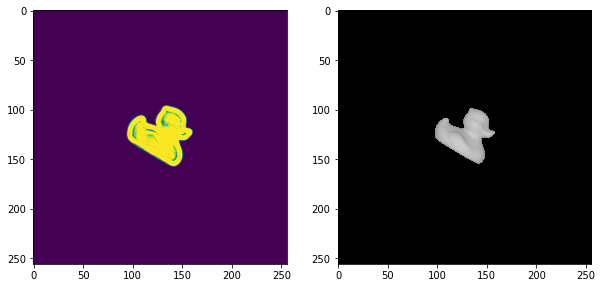

In [4]:
# Select the viewpoint using spherical angles  
distance = 400.0   # distance from camera to the object
elevation = 89.9   # angle of elevation in degrees
azimuth = 30.0  # angle of azimuth rotation in degrees

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# Render the teapot providing the values of R and T. 
silhouete = silhouette_renderer(meshes_world=model_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=model_mesh, R=R, T=T)

silhouete = silhouete.cpu().numpy()
image_ref = image_ref.cpu().numpy()

# image_ref = (image_ref>0.0).astype(np.float32)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouete.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
# plt.grid("off")
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
# plt.grid("off")

In [5]:
print(R)
print(T)

tensor([[[ 8.6603e-01, -5.0000e-01, -8.7265e-04],
         [-0.0000e+00,  1.7453e-03, -1.0000e+00],
         [ 5.0000e-01,  8.6602e-01,  1.5115e-03]]], device='cuda:0')
tensor([[ 6.2340e-09, -3.6856e-09,  4.0000e+02]], device='cuda:0')


In [6]:
# Camera position from R matrix given that object is at the origin.
c = -R[:,-1]
print(f'c: {c}')
print(c[:,1]/distance)
elev = torch.asin((c[:,1]/distance)) * 180/np.pi
azim = torch.asin((c[:,0]/(distance*torch.cos(elev)))) * 180/np.pi

print(f'elev: {elev}, azim: {azim}')

c: tensor([[-0.5000, -0.8660, -0.0015]], device='cuda:0')
tensor([-0.0022], device='cuda:0')
elev: tensor([-0.1240], device='cuda:0'), azim: tensor([-0.0722], device='cuda:0')


In [11]:
dist = 400.0   # distance from camera to the object
elev = 89.9   # angle of elevation in degrees
azim = 30.0  # angle of azimuth rotation in degrees

up = ((0, 1, 0),)
elev = elev * np.pi / 180.0
azim = azim * np.pi / 180.0

x = dist * np.cos(elev) * np.sin(azim)
y = dist * np.sin(elev)
z = -dist * np.cos(elev) * np.cos(azim)
camera_position = np.array([[x,y,z]])
print(f'camera_position: {camera_position}')

z_axis = -camera_position
z_axis /= np.linalg.norm(z_axis)
x_axis = np.cross(up, z_axis)
x_axis /= np.linalg.norm(x_axis)
y_axis = np.cross(z_axis, x_axis)
y_axis /= np.linalg.norm(y_axis)

R = np.vstack((x_axis, y_axis, z_axis))
R = R.transpose()
print(f'R: {R}')


camera_position: [[ 3.49065673e-01  3.99999391e+02 -6.04599481e-01]]
R: [[ 8.66025404e-01 -4.99999238e-01 -8.72664183e-04]
 [-0.00000000e+00  1.74532837e-03 -9.99998477e-01]
 [ 5.00000000e-01  8.66024085e-01  1.51149870e-03]]


In [10]:
dist = 400.0   # distance from camera to the object
elev = 90.1   # angle of elevation in degrees
azim = 30.0  # angle of azimuth rotation in degrees

up = ((0, 1, 0),)
elev = elev * np.pi / 180.0
azim = azim * np.pi / 180.0

x = dist * np.cos(elev) * np.sin(azim)
y = dist * np.sin(elev)
z = -dist * np.cos(elev) * np.cos(azim)
camera_position = np.array([[x,y,z]])
print(f'camera_position: {camera_position}')

z_axis = -camera_position
z_axis /= np.linalg.norm(z_axis)
x_axis = np.cross(up, z_axis)
x_axis /= np.linalg.norm(x_axis)
y_axis = np.cross(z_axis, x_axis)
y_axis /= np.linalg.norm(y_axis)

R = np.vstack((x_axis, y_axis, z_axis))
R = R.transpose()
print(f'R: {R}')


camera_position: [[-3.49065673e-01  3.99999391e+02  6.04599481e-01]]
R: [[-8.66025404e-01  4.99999238e-01  8.72664183e-04]
 [ 0.00000000e+00  1.74532837e-03 -9.99998477e-01]
 [-5.00000000e-01 -8.66024085e-01 -1.51149870e-03]]


In [8]:
z_axis = R[:,-1]
camera_position = -z_axis * dist
print(f'camera_position: {camera_position}')
print(elev)
elev = np.arcsin(camera_position[1]/dist)
azim = np.arcsin(camera_position[0]/(dist*np.cos(elev)))
# azim = np.arccos(-camera_position[2]/(dist*np.cos(elev)))
print(f'elev: {elev * 180/np.pi}, azim: {azim * 180/np.pi}')


camera_position: [ 3.49065673e-01  3.99999391e+02 -6.04599481e-01]
1.5690509975429023
elev: 89.90000000000346, azim: 30.000000001140503


## Batched rendering

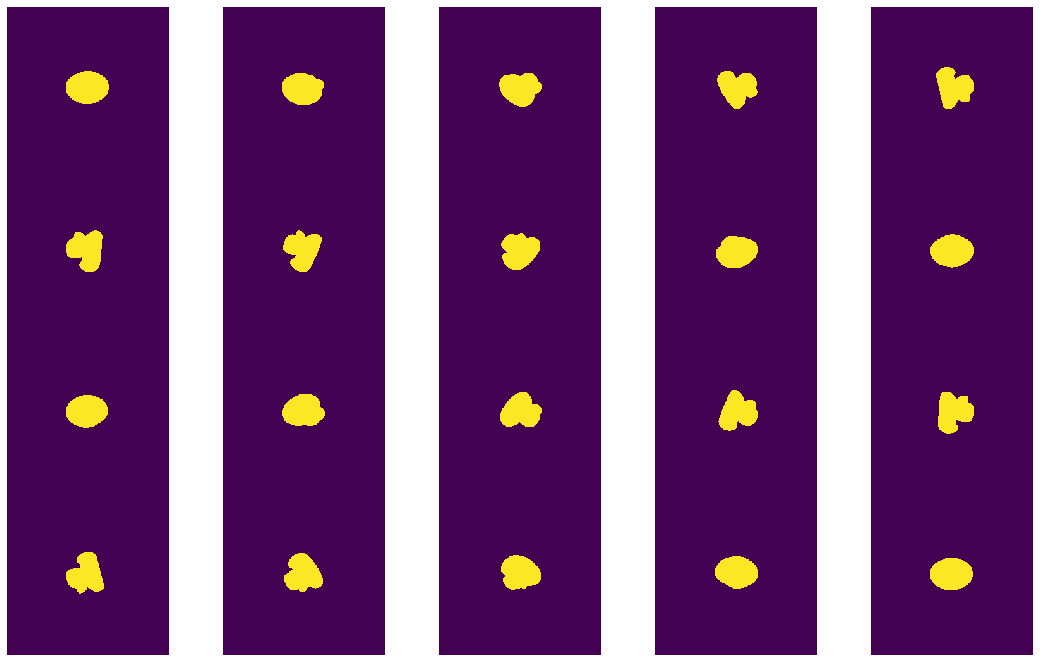

In [9]:
# Set batch size - this is the number of different viewpoints from which we want to render the mesh.
batch_size = 20

# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = model_mesh.extend(batch_size)

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, batch_size)
azim = torch.linspace(0, 360, batch_size)

# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and specify dist=2.7 as a float,
# and then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=400, elev=elev, azim=azim)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# Move the light back in front of the object
lights.location = torch.tensor([[1.0, 1.0, -5.0]], device=device)

# We can pass arbirary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = silhouette_renderer(meshes, cameras=cameras, lights=lights)
images = (images>0).float()
image_grid(images.cpu().numpy(), rows=4, cols=5, rgb=False)